# Playground Competition Season 04 Episode 03
Here I will continue investigate depth and width of the NN. From the previous, 002, I have gotten 'Lemon' scores. We did an exhaustive search of the best 3-layer combo with 16,32,64 and 128 units. I will start to implement batch normalization as well as drop-out techniques.

| Model       | Focus area             | Submitted AUC score |
|-------------|------------------------|---------------------|
| Vanilla 0.1 | None                   | 0.54859             |
| Vanilla 0.2 | Standardize input data | 0.57534             |
| Vanilla 0.3 | Re-sampling data       | 0.49236             |
| Lemon   1.0 | Default 3-layers       | 0.85335             |
| Lemon   1.1 | Best 3-combo layers    | 0.86289             |

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')

# Seperate X,y
prediction_categories = train_data.columns.drop(test_data.columns)
X_full = train_data.drop(prediction_categories, axis=1)
y_full = train_data[prediction_categories].copy()
assert(X_full.shape[1] == test_data.shape[1])

from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2)
X_test = test_data.copy()

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pick columns with a 'large' mean, 
# I will chose 2.5 just to avoid manipulation the Log-based categories
cols_to_std = [c for c in X_train.columns if X_train[c].mean() > 2.5]

# Bundle preprocessing for numerical and categorical data
my_preprocessor = ColumnTransformer(
    transformers=[
        ('large mean', StandardScaler(), cols_to_std),
    ])
X_train[cols_to_std] = my_preprocessor.fit_transform(X_train)
X_valid[cols_to_std] = my_preprocessor.transform(X_valid)
X_test[cols_to_std] = my_preprocessor.transform(test_data)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras import Input

num_classes = y_train.shape[1]
num_features = X_train.shape[1]

def get_model(learning_rate=0.3,layers=[64,32,16],drop_out=0.) -> Sequential:
    # Create a Sequential model
    model = Sequential()
    model.add(Input(shape=(num_features,)))

    for n in layers:
        model.add(Dropout(rate=drop_out, seed=42))
        model.add(BatchNormalization())
        model.add(Dense(units=n,activation='relu'))
        
    model.add(Dense(units=num_classes, activation='softmax'))
    #model.layers[0].input_shape = (num_features,)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
                  metrics=['accuracy','auc'])

    # Name the model
    model.name = 'Pear' 
    return model

def train_model(model,batch_size=512,verbose=0):
    early_stopping = get_early_stopping()
    
    history = model.fit(
        X_train,y_train,
        validation_data=(X_valid,y_valid),
        batch_size=batch_size,
        epochs=999,
        callbacks=[early_stopping],
        verbose=verbose
    )

    return model,history


2024-03-05 09:48:12.688460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 09:48:12.688590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 09:48:12.836567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
def get_early_stopping(patience=25,min_delta=0.001) -> EarlyStopping:
    return EarlyStopping(monitor='val_loss',
                         patience=patience, 
                         min_delta=min_delta,
                         restore_best_weights=True,
                         verbose=0,
                        )

# Helper func to display metrics from training history
def print_metrics(history) -> None:
    idx = np.argmin(history.history['val_loss'])
    print(f'Epochs until best result: {idx}')
    print(f'Best validation accuracy: {history.history["val_accuracy"][idx]}')
    print(f'Best validation auc     : {history.history["auc"][idx]}')
    print(f'Best validation loss    : {history.history["val_loss"][idx]}')
    
# Helper func to plot metrics from training history
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def plot_metrics(history,start=1) -> None:
    
    history_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot loss and val_loss
    loss_plot = history_df.loc[start:, ['loss', 'val_loss']].plot(ax=axes[0], title="Categorical Cross-Entropy")
    loss_plot.set_xlabel("Epoch")

    # Plot accuracy and val_accuracy
    accuracy_plot = history_df.loc[start:, ['accuracy', 'val_accuracy']].plot(ax=axes[1], title="Accuracy")
    accuracy_plot.set_xlabel("Epoch")

    # Plot auc and val_auc
    auc_plot = history_df.loc[start:, ['auc', 'val_auc']].plot(ax=axes[2], title="AUC")
    auc_plot.set_xlabel("Epoch")

    plt.tight_layout()  # Adjust spacing between plots
    plt.show()
    
def plot_result(result):
    # result[0] = [(x_name,x_value),(y_name,y_value)]
    (x_name,_),(y_name,_) = result[0]

    # Extract x and y values
    x_values = []
    y_values = []
    
    for (_,x),(_,y) in result:
        x_values.append(x)
        y_values.append(y)
        
    # Create line plot
    plt.plot(x_values, y_values)

    # Set labels and title
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f'{y_name} vs. {x_name}')


New model: Pear
Epochs until best result: 2
Best validation accuracy: 0.30306971073150635
Best validation auc     : 0.8872072100639343
Best validation loss    : 3.520232677459717


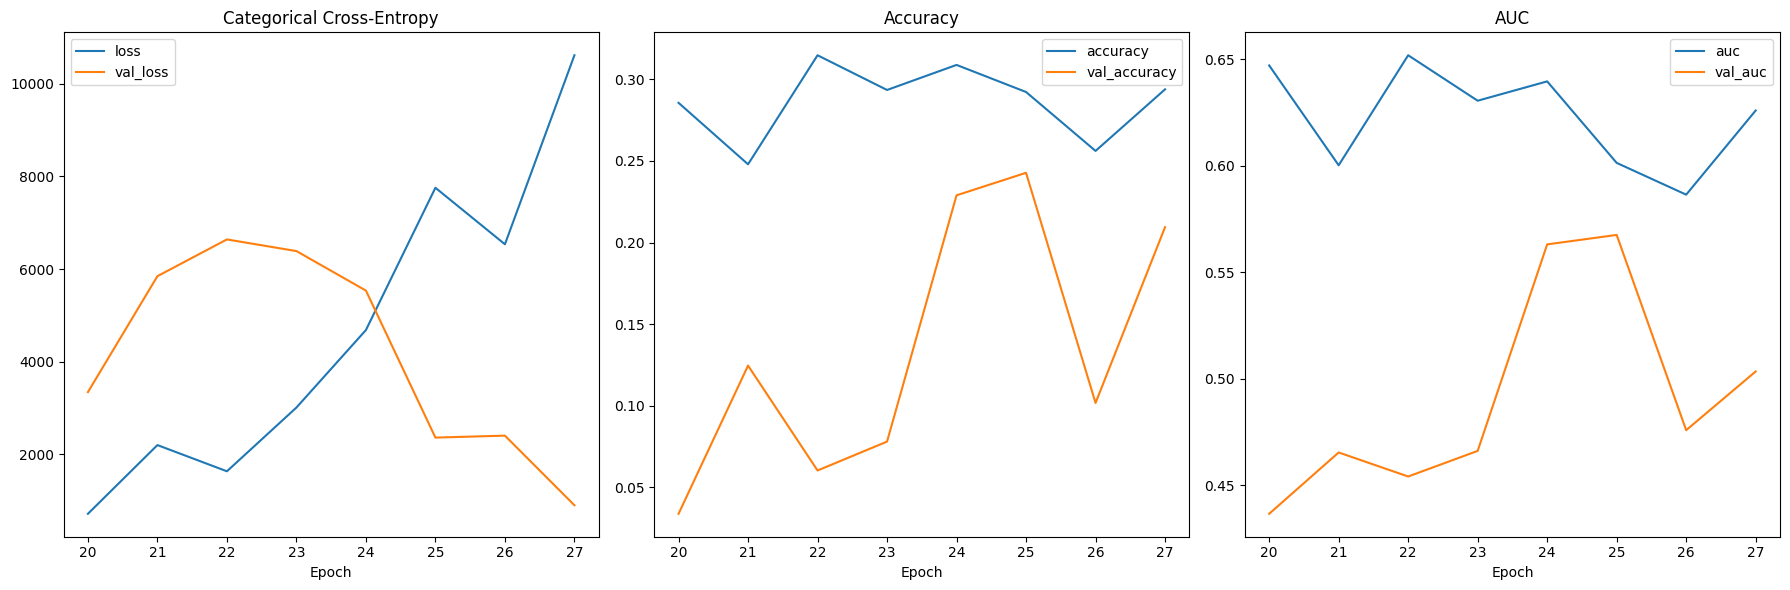

In [4]:
layers = [128,32,32,16]
# Get a new model, although keep the learning rate at 0.0001
model = get_model(learning_rate=0.1,layers=layers,drop_out=0)
print(f'New model: {model.name}')
# Train the model
model,history = train_model(model,batch_size=1024)

# Plot the metrics
print_metrics(history)
plot_metrics(history,start=20)

New model: Pear with batch_size at 32
Epochs until best result: 30
Best validation accuracy: 0.5548907518386841
Best validation auc     : 0.9152359962463379
Best validation loss    : 0.9270547032356262


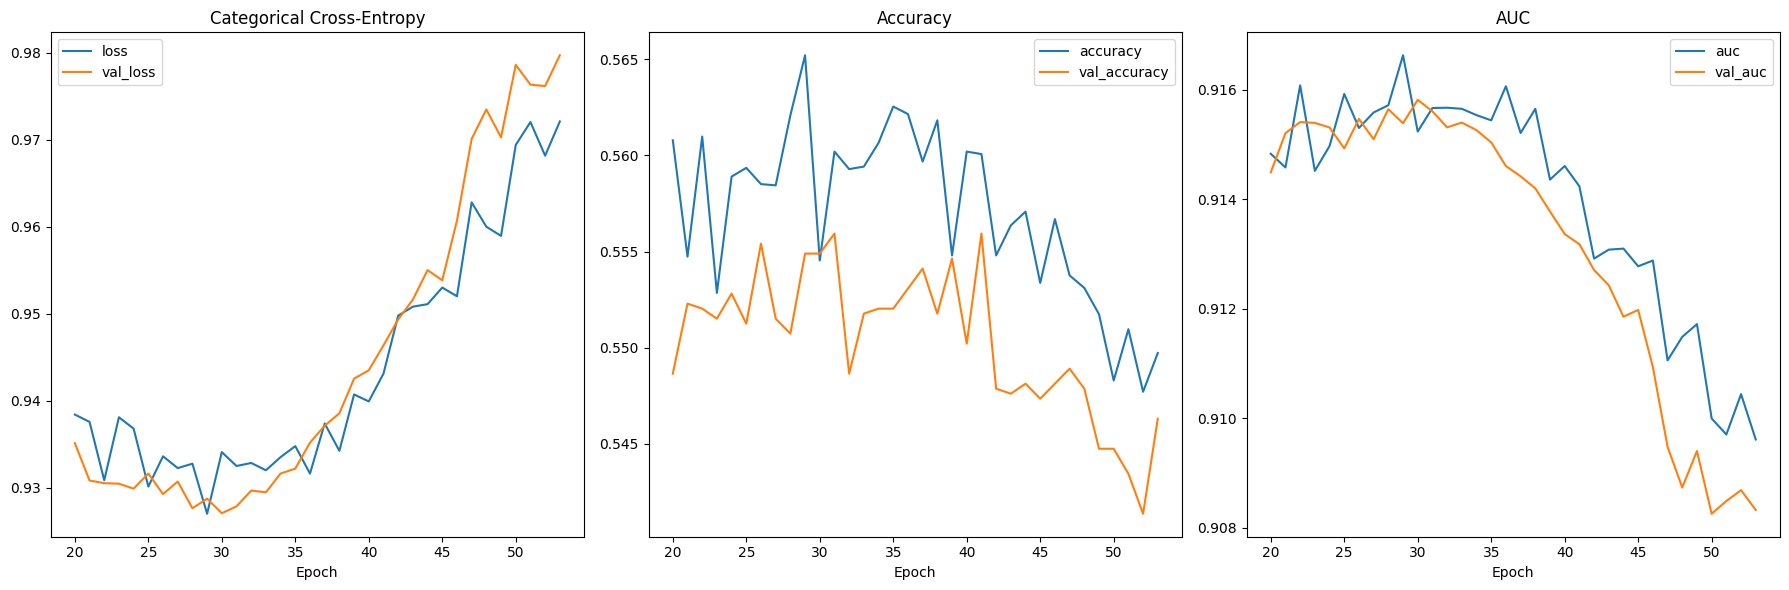

New model: Pear with batch_size at 256
Epochs until best result: 69
Best validation accuracy: 0.5455254912376404
Best validation auc     : 0.9236451387405396
Best validation loss    : 0.9645012617111206


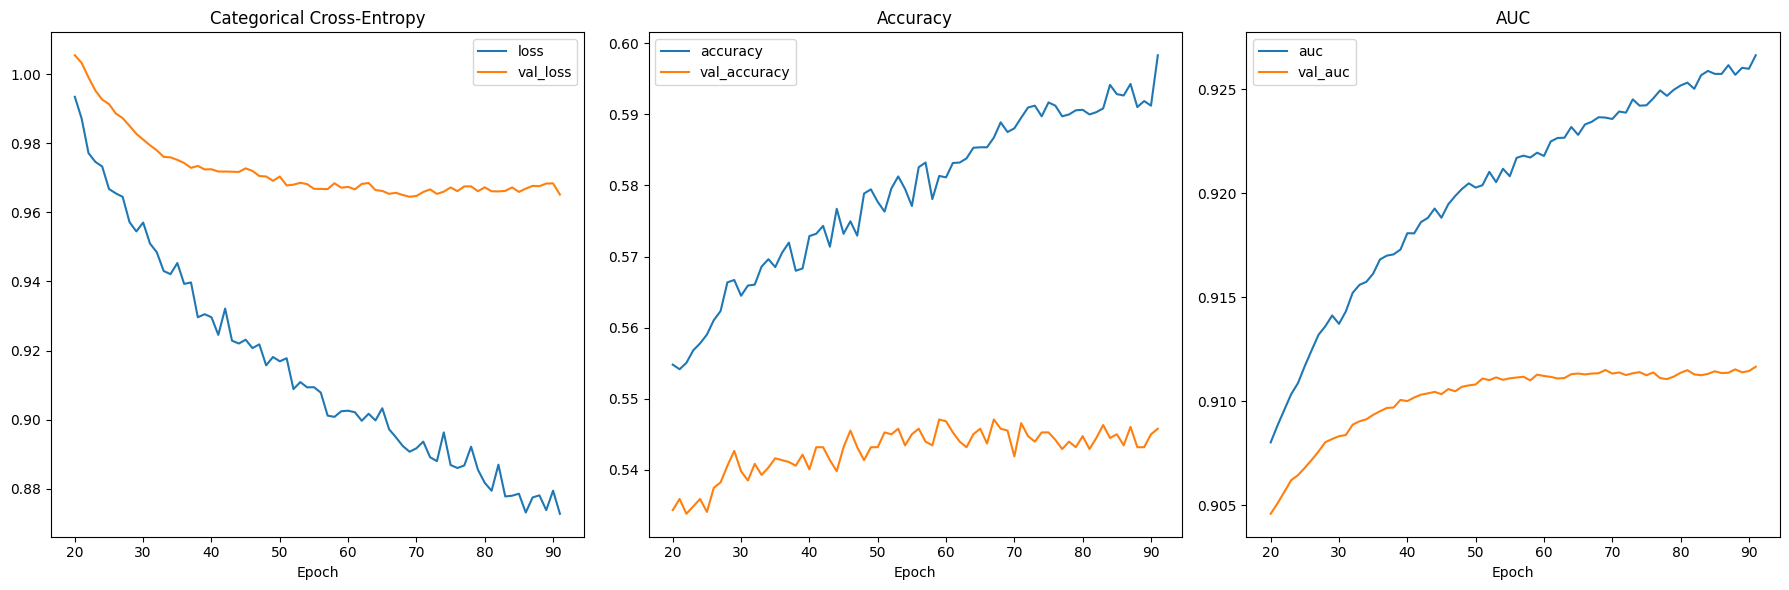

New model: Pear with batch_size at 1024
Epochs until best result: 277
Best validation accuracy: 0.5528095960617065
Best validation auc     : 0.9239233732223511
Best validation loss    : 0.9402787685394287


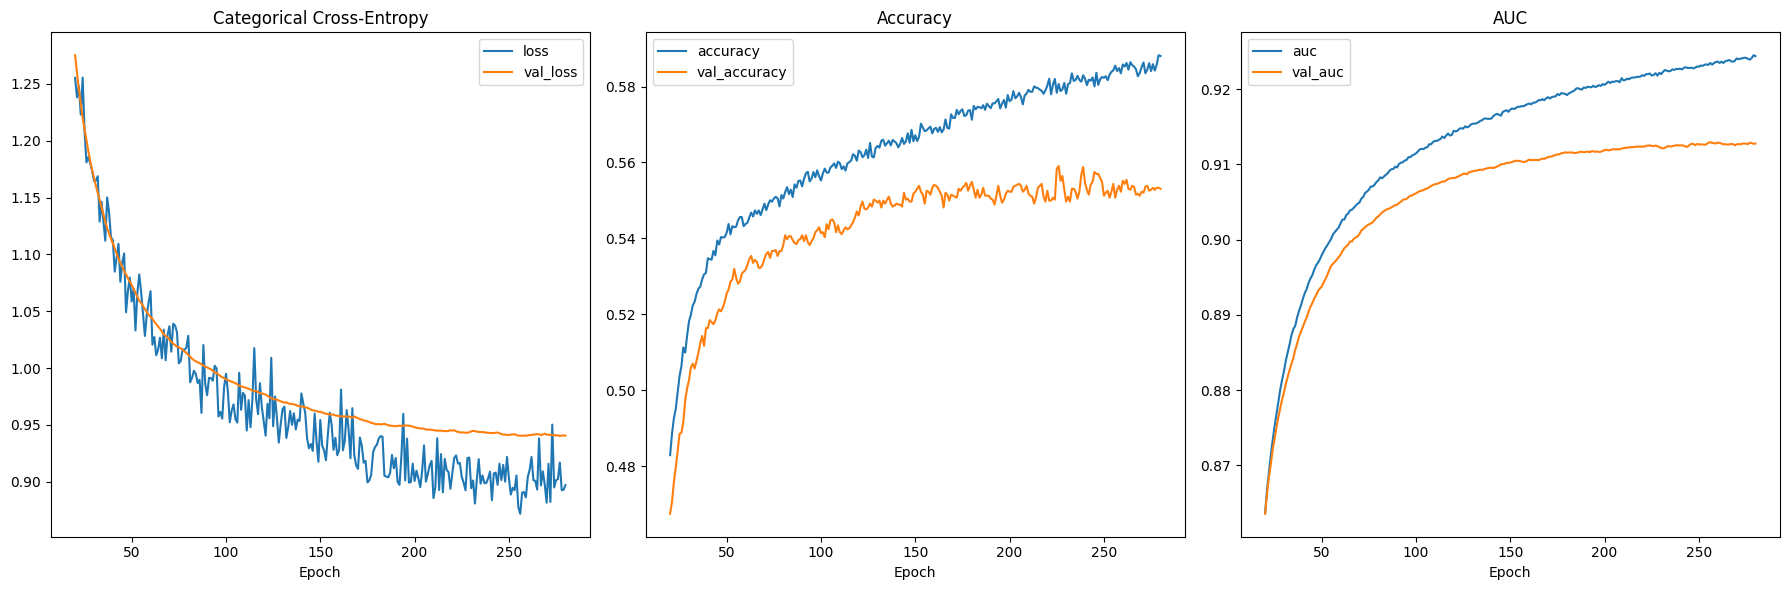

New model: Pear with batch_size at 2048
Epochs until best result: 306
Best validation accuracy: 0.5515088438987732
Best validation auc     : 0.929478645324707
Best validation loss    : 0.9659512042999268


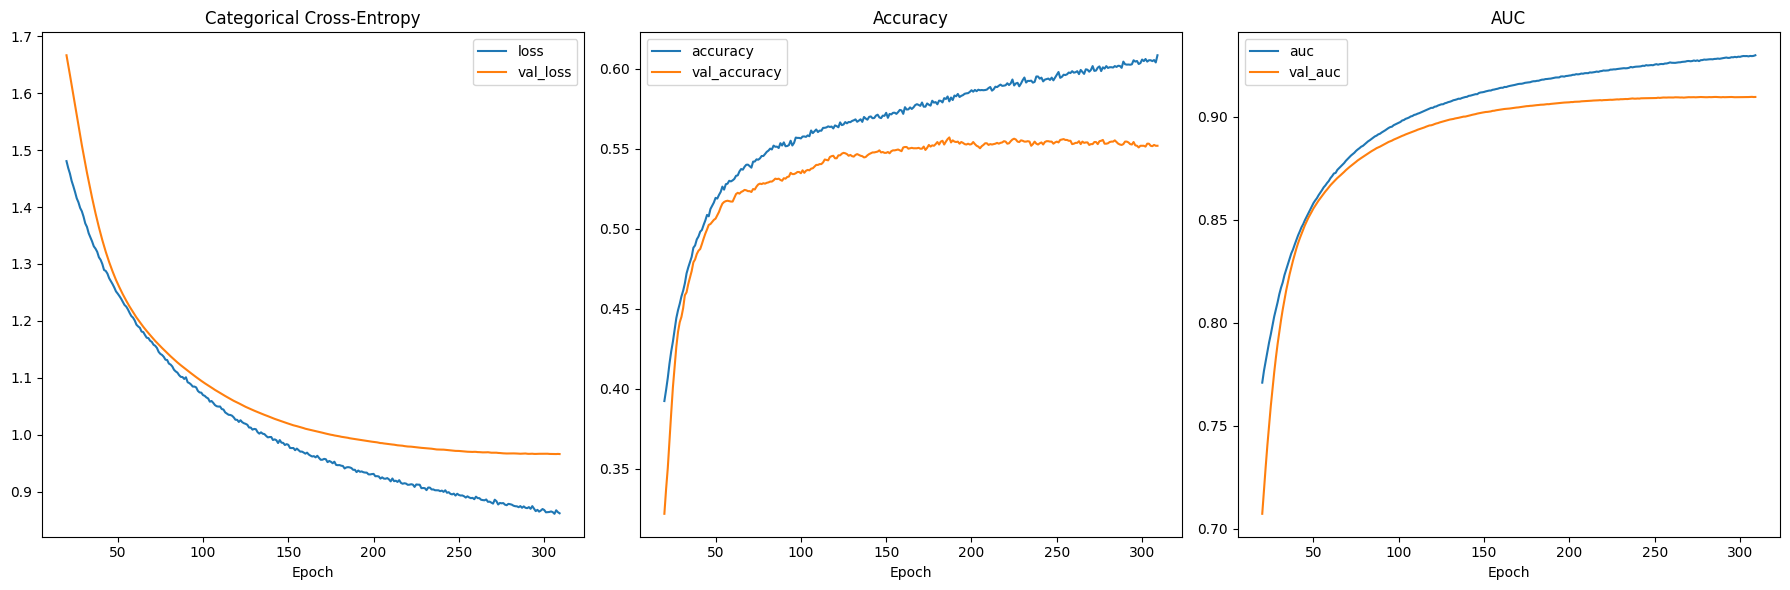

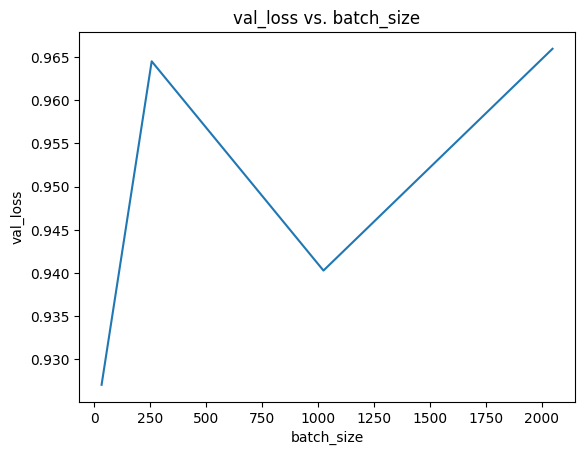

In [5]:
layers = [128,32,32,16]

# Save best results
best_model = None
min_loss = 99999999.0

result = []

# Settings to test
batch_size_list = [32,256,1024,2048]
best_batch_size = 32

for batch_size in batch_size_list:
    model = get_model(learning_rate=0.0001,layers=layers,drop_out=0.)
    print(f'New model: {model.name} with batch_size at {batch_size}')
    # Train the model
    model,history = train_model(model,batch_size=batch_size)

    # Plot the metrics
    print_metrics(history)
    plot_metrics(history,start=20)
    loss = min(history.history['val_loss'])
    result.append([('batch_size',batch_size), ('val_loss',loss)])

    if loss < min_loss:
        min_loss = min(history.history['val_loss'])
        best_model = model
        best_batch_size = batch_size
        
plot_result(result)

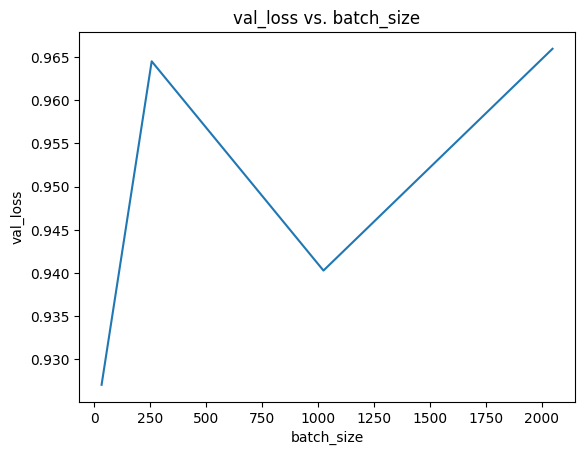

In [6]:
plot_result(result)

New model: Pear with drop out at 0.001
Epochs until best result: 26
Best validation accuracy: 0.5520291328430176
Best validation auc     : 0.9160021543502808
Best validation loss    : 0.9295994639396667


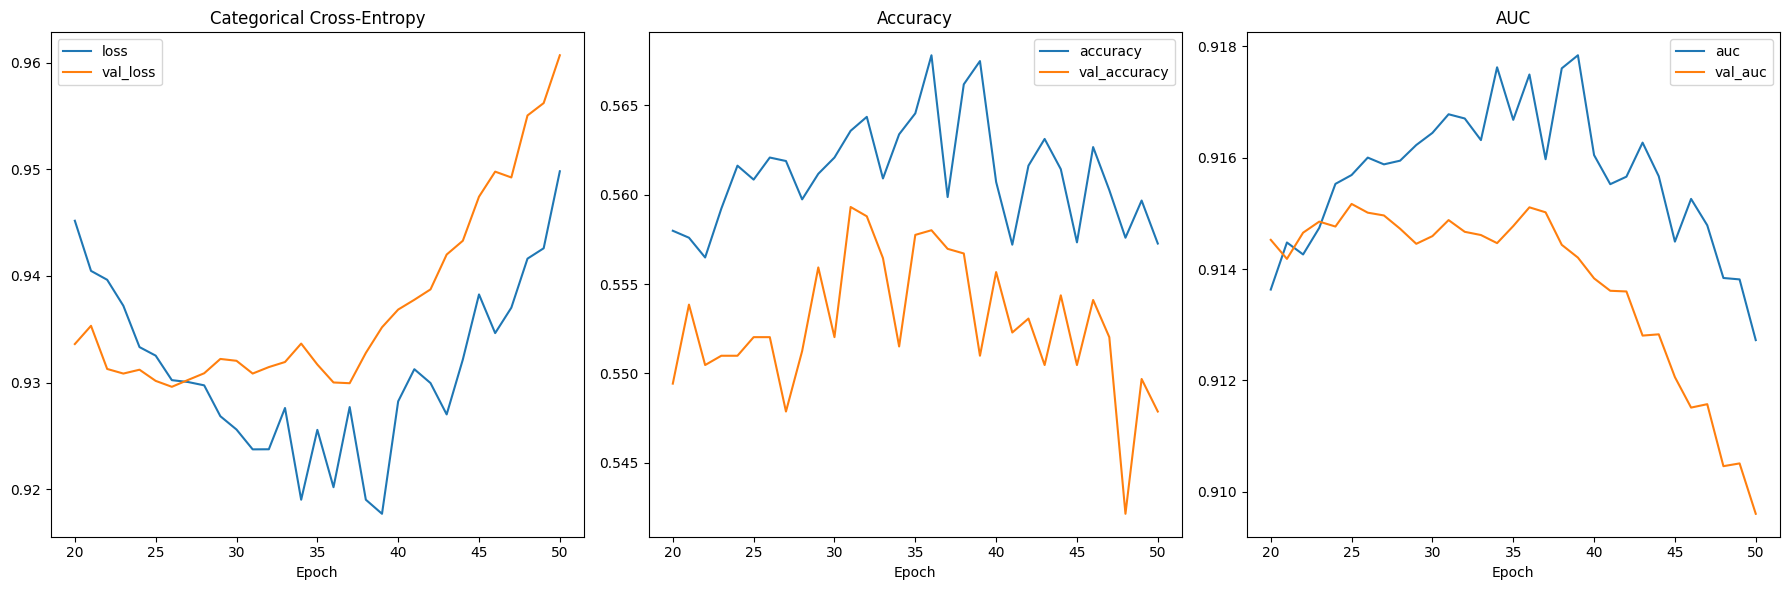

New model: Pear with drop out at 0.01
Epochs until best result: 48
Best validation accuracy: 0.5577523708343506
Best validation auc     : 0.9156310558319092
Best validation loss    : 0.9224910140037537


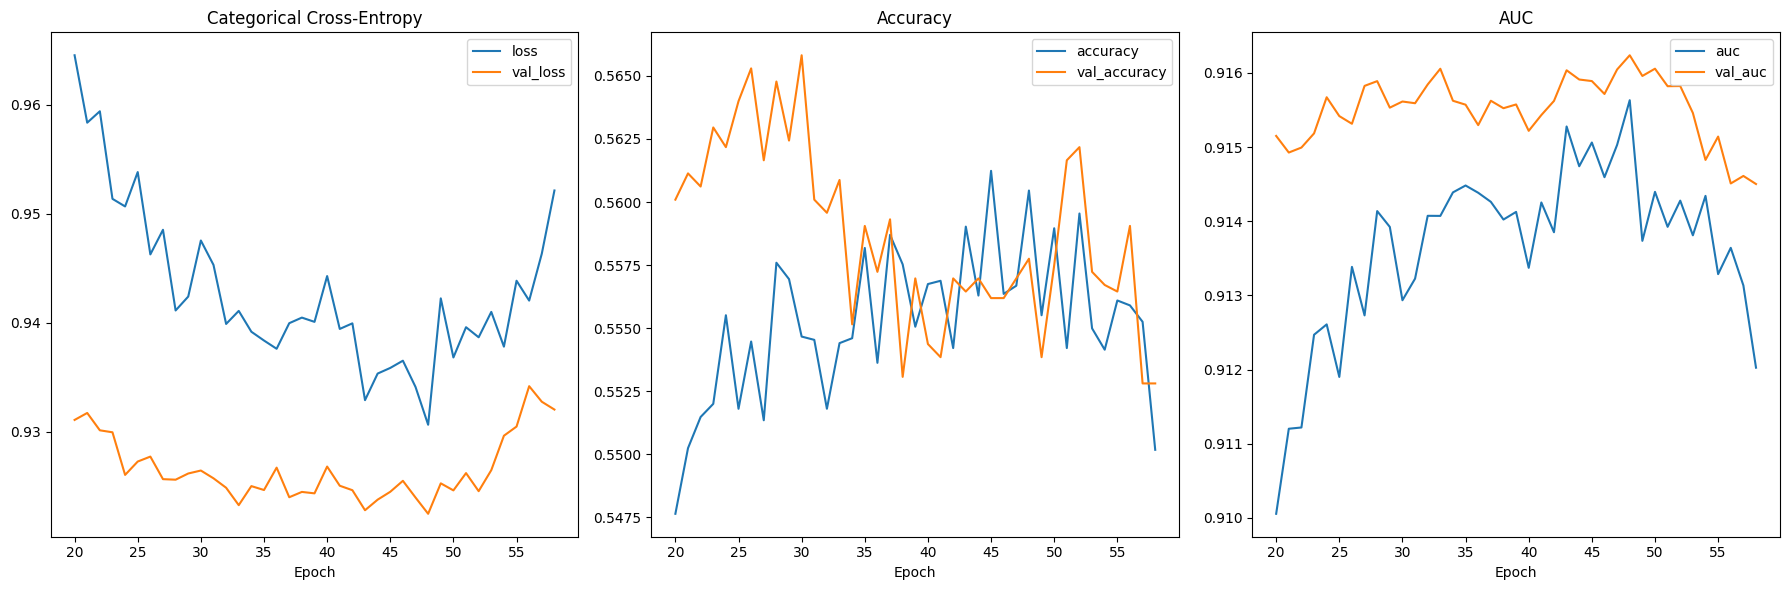

New model: Pear with drop out at 0.05
Epochs until best result: 27
Best validation accuracy: 0.5512486696243286
Best validation auc     : 0.9026331305503845
Best validation loss    : 0.942797839641571


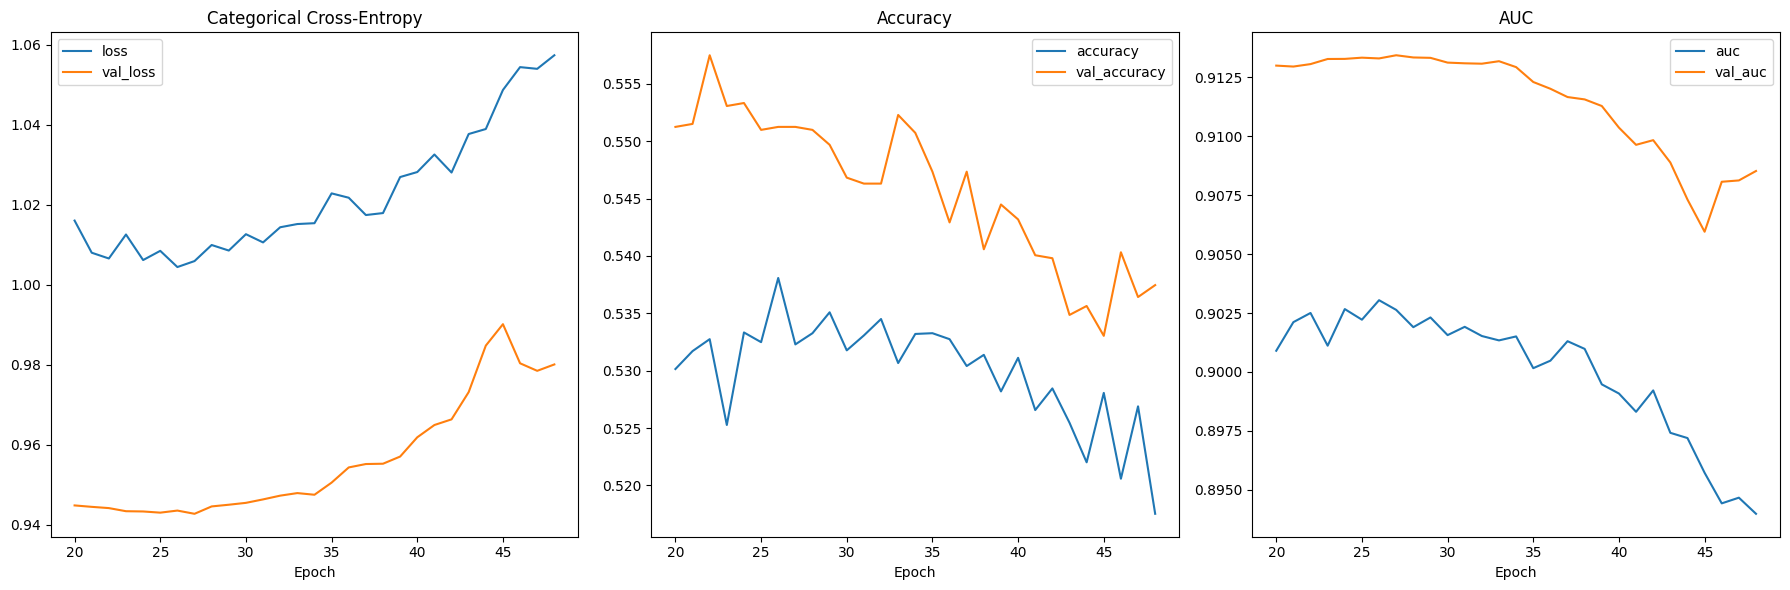

New model: Pear with drop out at 0.1
Epochs until best result: 35
Best validation accuracy: 0.5528095960617065
Best validation auc     : 0.8964987397193909
Best validation loss    : 0.9475206732749939


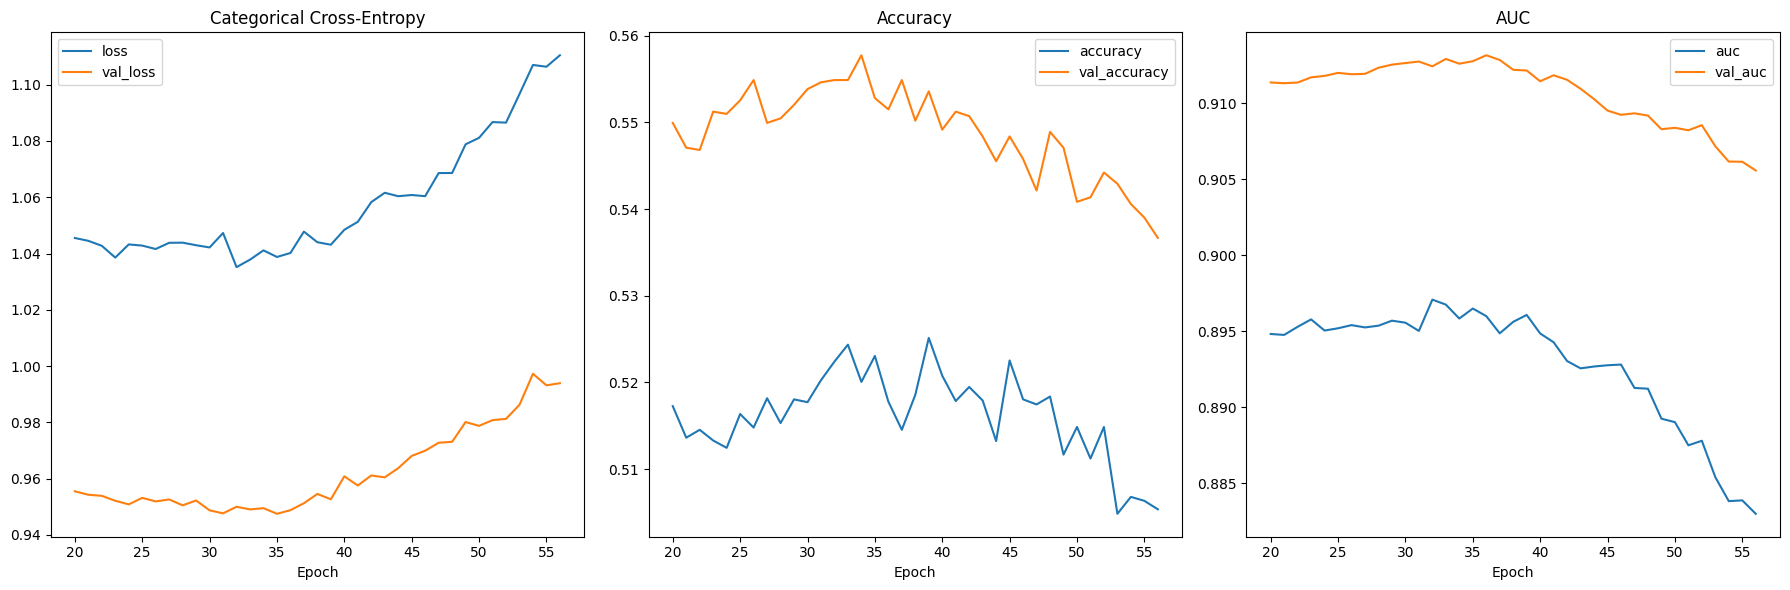

New model: Pear with drop out at 0.15
Epochs until best result: 32
Best validation accuracy: 0.5470863580703735
Best validation auc     : 0.8939076066017151
Best validation loss    : 0.9596548080444336


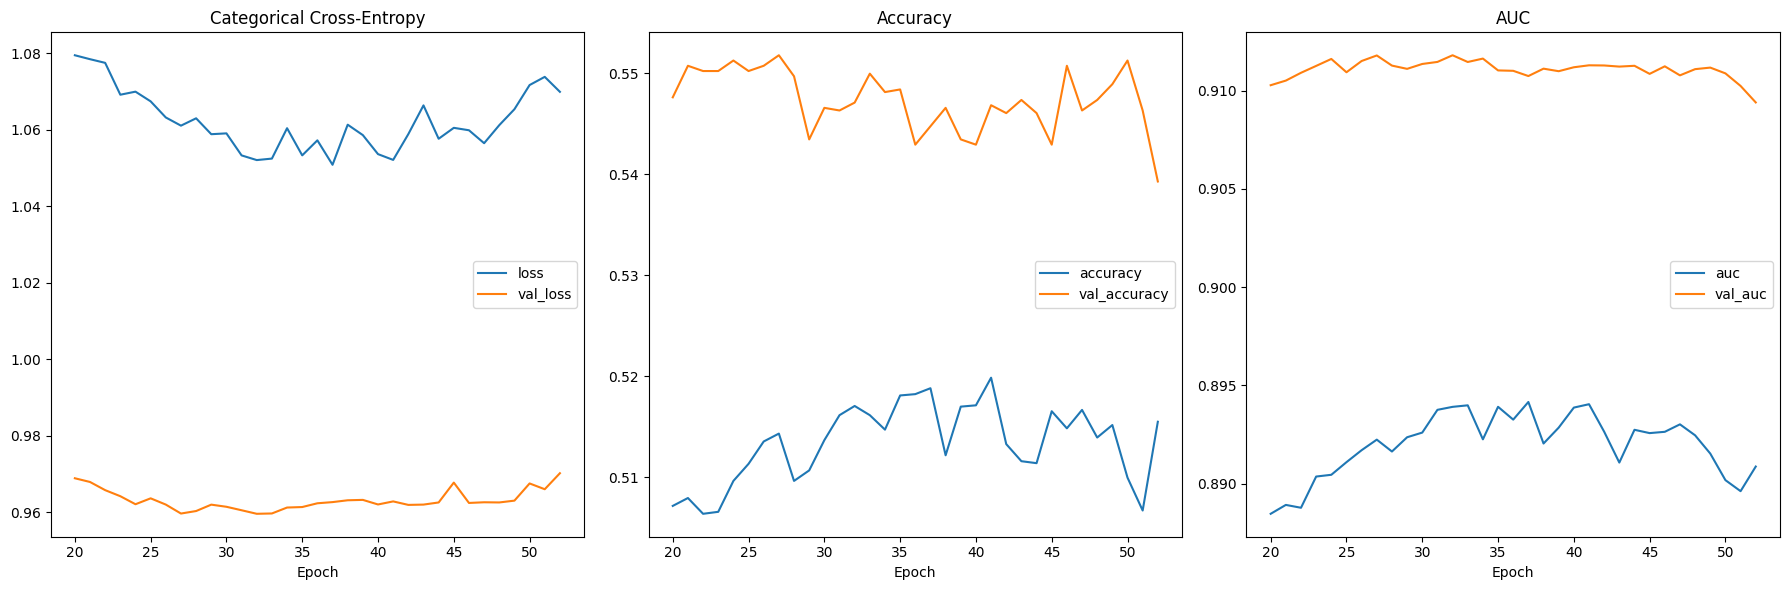

New model: Pear with drop out at 0.2
Epochs until best result: 41
Best validation accuracy: 0.5338189601898193
Best validation auc     : 0.8882520794868469
Best validation loss    : 0.9853828549385071


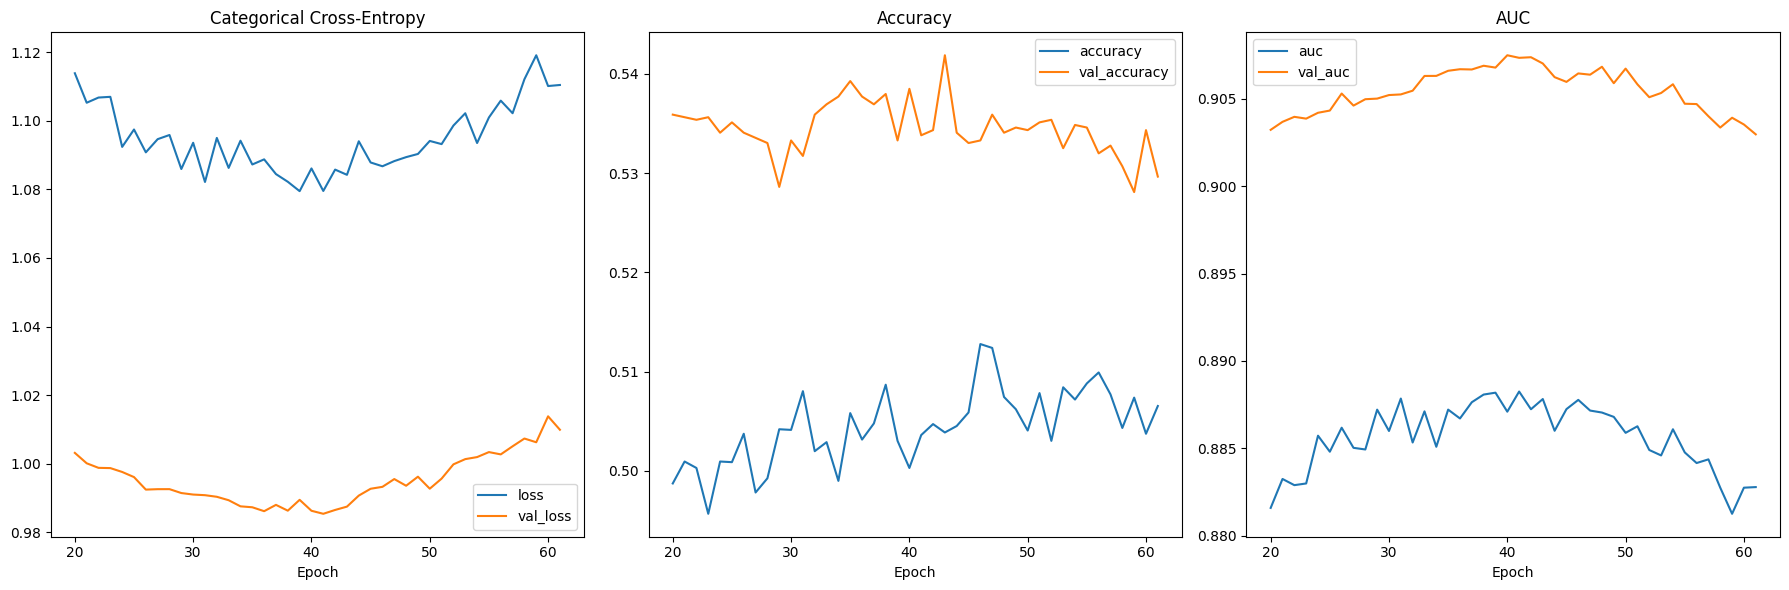

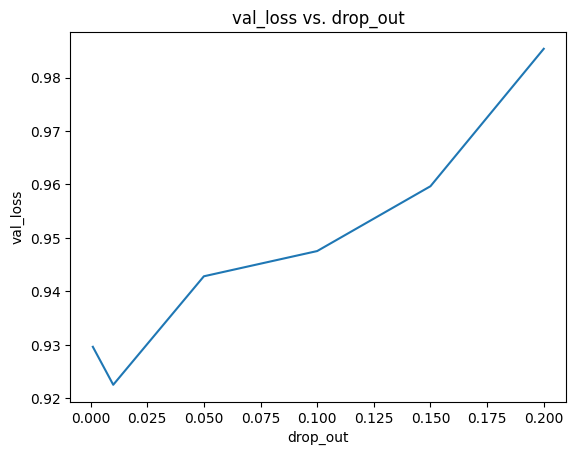

In [7]:
drop_out_list = [0.001,0.01,0.05,0.1,0.15,0.2]
best_drop_out = 0.
result = []

for drop_out in drop_out_list:
    model = get_model(learning_rate=0.0001,layers=layers,drop_out=drop_out)
    print(f'New model: {model.name} with drop out at {drop_out}')
    # Train the model
    model,history = train_model(model,batch_size=best_batch_size)

    # Plot the metrics
    print_metrics(history)
    plot_metrics(history,start=20)
    loss = min(history.history['val_loss'])
    result.append([('drop_out',drop_out), ('val_loss',loss)])

    if loss < min_loss:
        min_loss = min(history.history['val_loss'])
        best_model = model
        best_drop_out = drop_out
        
plot_result(result)
result_drop_out = result

New model: Pear with learning rate at 0.001
Epochs until best result: 1
Best validation accuracy: 0.5486472249031067
Best validation auc     : 0.9040505290031433
Best validation loss    : 0.9496175646781921


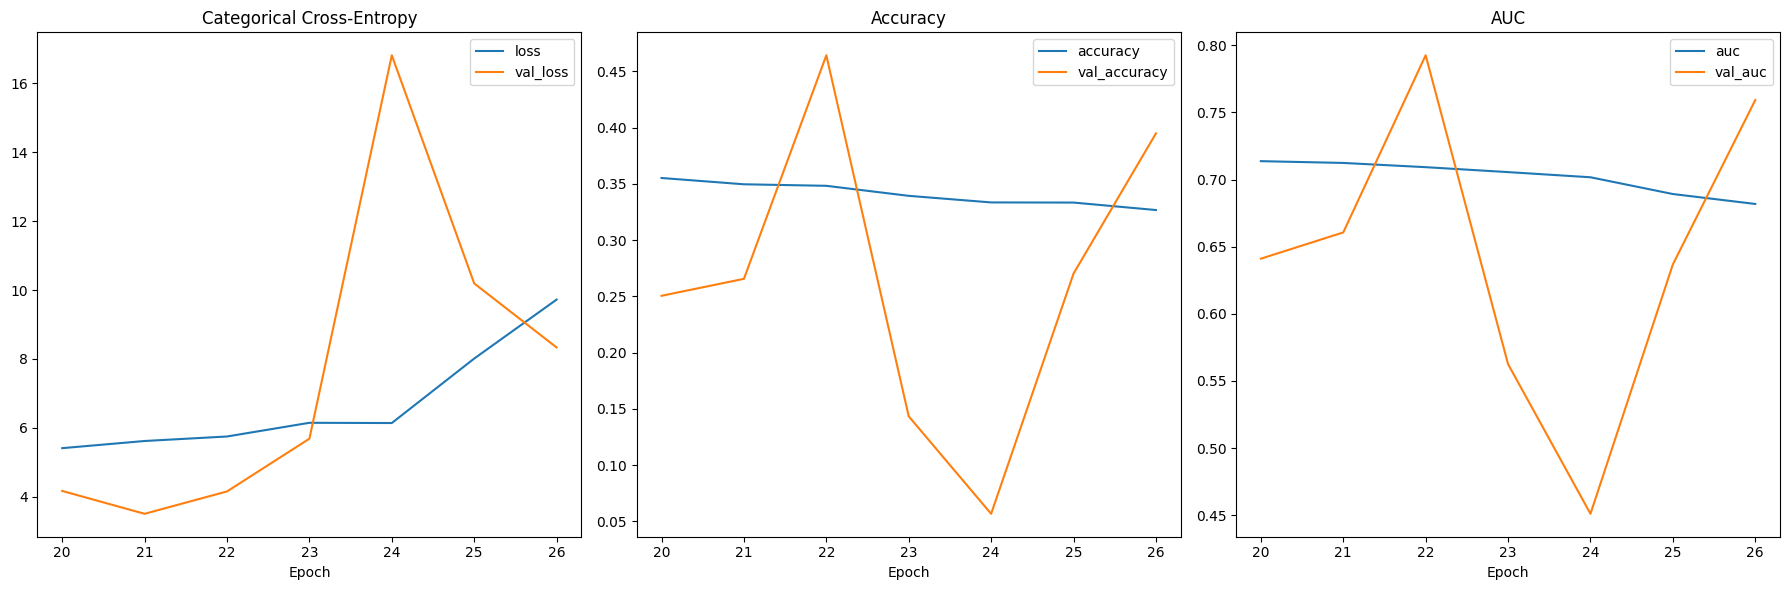

New model: Pear with learning rate at 5e-05
Epochs until best result: 70
Best validation accuracy: 0.5546305775642395
Best validation auc     : 0.9126526117324829
Best validation loss    : 0.9279206395149231


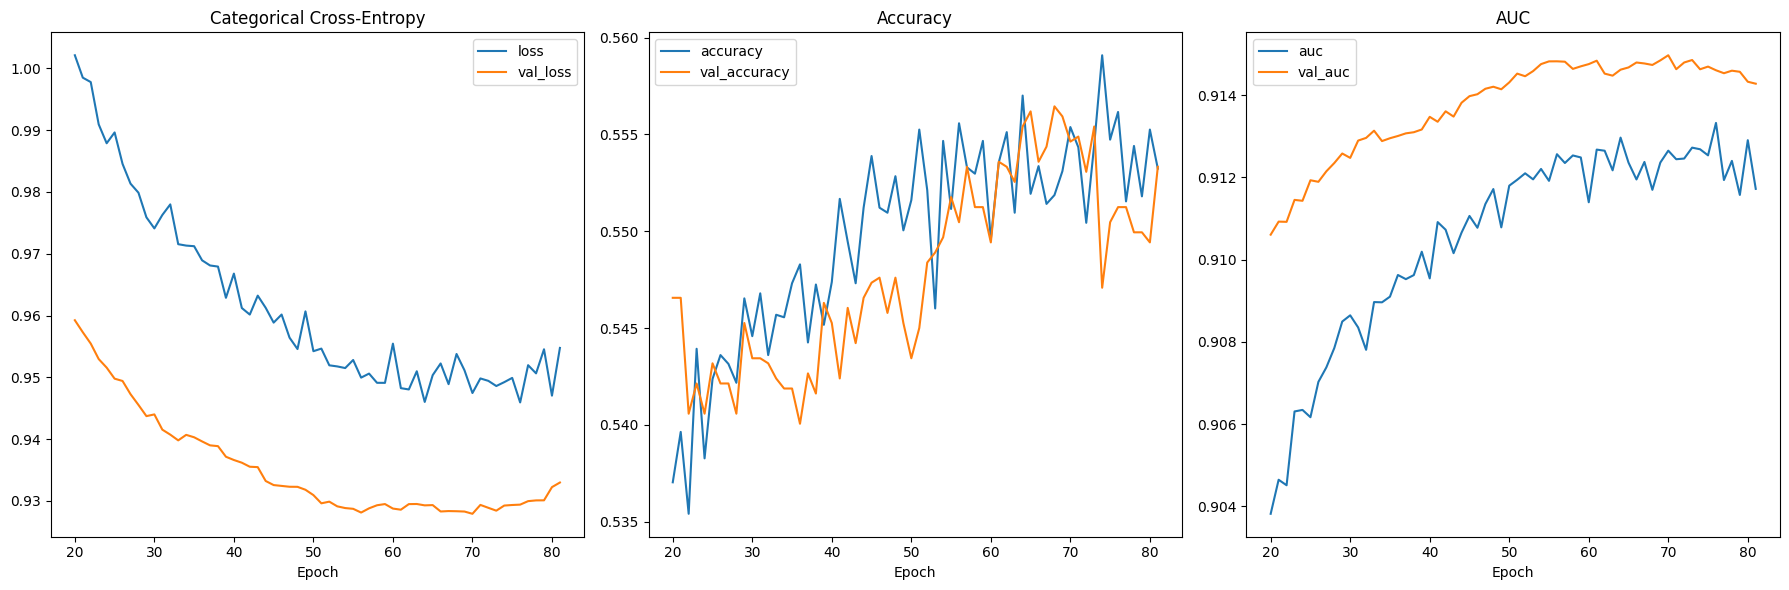

New model: Pear with learning rate at 1e-05
Epochs until best result: 219
Best validation accuracy: 0.5598335266113281
Best validation auc     : 0.9118415713310242
Best validation loss    : 0.9244202375411987


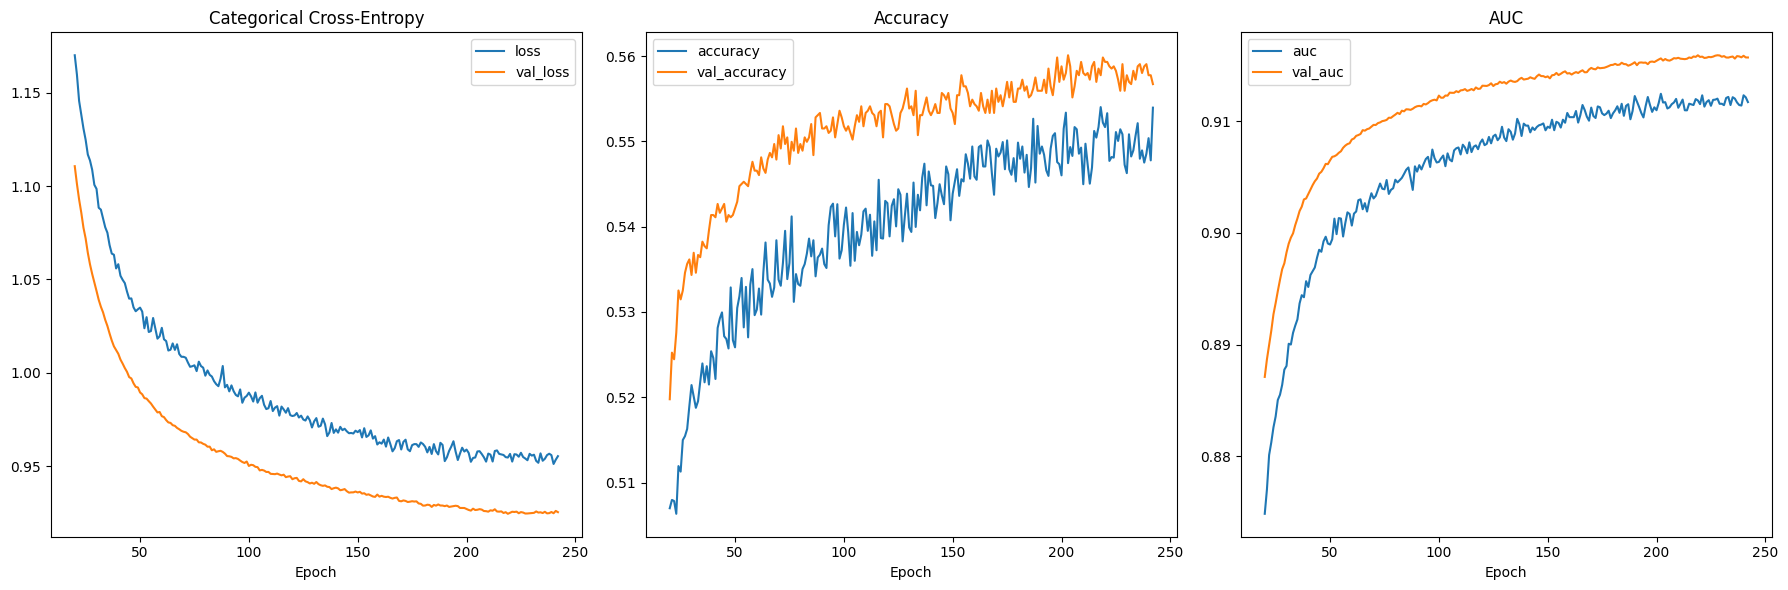

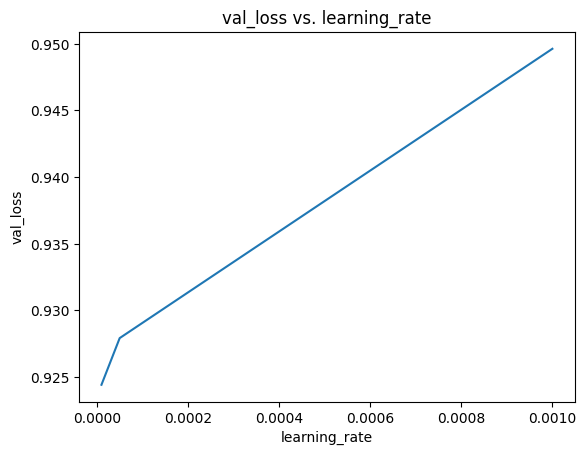

In [8]:
learning_rate_list = [0.001,0.00005,0.00001]
best_learning_rate = 0.0001
result = []

for learning_rate in learning_rate_list:
    model = get_model(learning_rate=learning_rate,layers=layers,drop_out=best_drop_out)
    print(f'New model: {model.name} with learning rate at {learning_rate}')
    # Train the model
    model,history = train_model(model,batch_size=best_batch_size)

    # Plot the metrics
    print_metrics(history)
    plot_metrics(history,start=20)
    loss = min(history.history['val_loss'])
    result.append([('learning_rate',learning_rate), ('val_loss',loss)])

    if loss < min_loss:
        min_loss = min(history.history['val_loss'])
        best_model = model
        best_learning_rate = learning_rate
        
plot_result(result)

In [9]:
print(f"batch size: {best_batch_size}, drop out: {best_drop_out}, learning rate: {best_learning_rate}")

batch size: 32, drop out: 0.01, learning rate: 0.0001


In [10]:
batch_size = best_batch_size
drop_out = best_drop_out
learning_rate = best_learning_rate

New model: Pear with learning_rate @ 0.0001, drop_out @ 0.01 and training with batch_size @ 32
Epochs until best result: 24
Best validation accuracy: 0.557492196559906
Best validation auc     : 0.9099999070167542
Best validation loss    : 0.9288044571876526


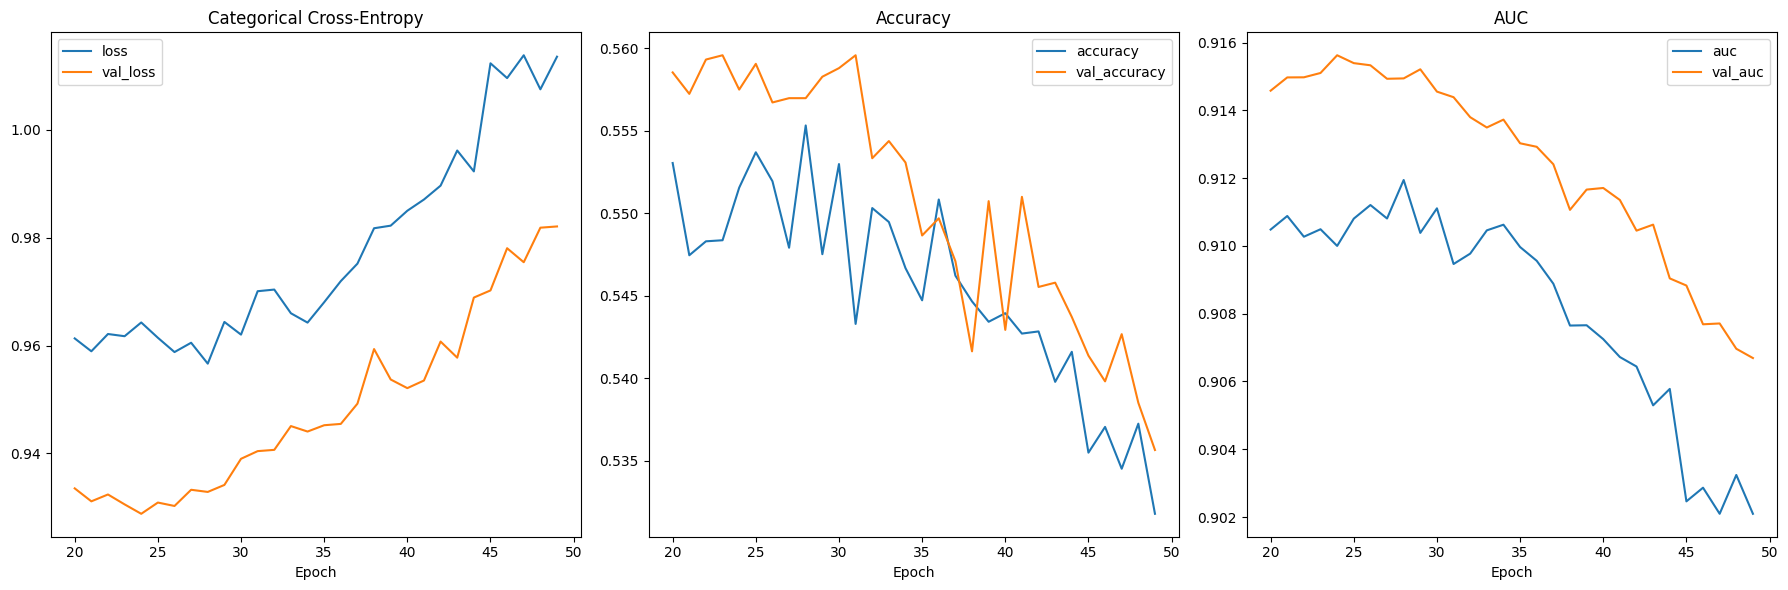

In [11]:
# Get a new model from new settings
model = get_model(learning_rate=learning_rate,layers=layers,drop_out=drop_out)
print(f'New model: {model.name} with learning_rate @ {learning_rate}, drop_out @ {drop_out} and training with batch_size @ {batch_size}')
# Train the model
model,history = train_model(model,batch_size=batch_size)

# Plot the metrics
print_metrics(history)
plot_metrics(history,start=20)

New model: Pear with learning_rate @ 0.0001, drop_out @ 0.05 and training with batch_size @ 256
Epochs until best result: 166
Best validation accuracy: 0.5564516186714172
Best validation auc     : 0.9128987193107605
Best validation loss    : 0.9253661632537842


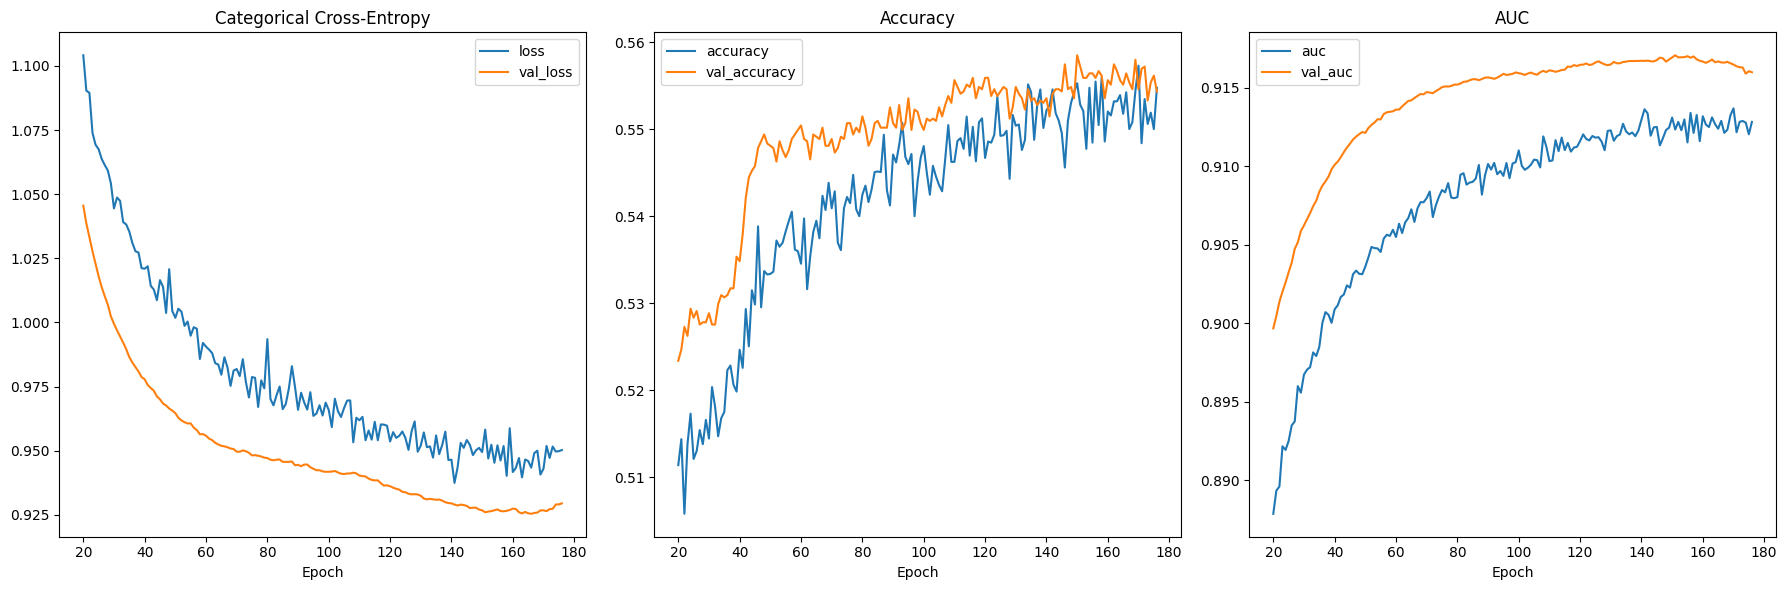

In [12]:
# Alternative
# Batch Size = 256, Got the best AUC as well as no over-shooting
# Drop Out = 0.05, Might need more drop out since higher batch size tends to overfit
# Learning Rate = 0.0001, Keep the one used during test of other settings
# Get a new model from new settings
model_02 = get_model(learning_rate=0.0001,layers=layers,drop_out=0.05)
print(f'New model: {model_02.name} with learning_rate @ {0.0001}, drop_out @ {0.05} and training with batch_size @ {256}')
# Train the model
model_02,history = train_model(model_02,batch_size=256)

# Plot the metrics
print_metrics(history)
plot_metrics(history,start=20)

### Conclusion
The alternative model do perform better according to validation loss, however our model from the tests do produce a higher AUC. Since the metrics for this competition is AUC I will not use the alternative model.

In [13]:
# Re-train on all train data
preprocessor = ColumnTransformer(
    transformers=[
        ('large mean', StandardScaler(), cols_to_std),
    ])

X_full[cols_to_std] = preprocessor.fit_transform(X_full)

In [14]:
# Train and submit
X_test = test_data
X_test[cols_to_std] = preprocessor.transform(test_data)
y_hat = model.predict(X_test)

output = pd.DataFrame(y_hat, columns=y_train.columns, index=test_data.index)
print(output.head())
output.to_csv('submission_pear_005.csv', index=True)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
         Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
id                                                                    
19219  0.492902   0.016133  0.005933  0.001416   0.035774  0.110945   
19220  0.222172   0.021951  0.008676  0.000768   0.123325  0.173134   
19221  0.005049   0.040815  0.046367  0.014092   0.005620  0.318959   
19222  0.136125   0.037706  0.004332  0.001661   0.010254  0.417964   
19223  0.020862   0.012574  0.000886  0.000815   0.009053  0.537847   

       Other_Faults  
id                   
19219      0.336899  
19220      0.449974  
19221      0.569098  
19222      0.391959  
19223      0.417962  
